Report link: https://www.overleaf.com/project/6447fc10647c07d8264ee3c8

## Import Libraries

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import simpy
import random
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Import Data

In [ ]:
#Loading in the csv of all the flights
url = 'https://www.dropbox.com/s/jtkwvbycj9pzqi1/flights.csv?dl=1'
flights = df = pd.read_csv(url) #This data is the 2015 flights data that can be found on Kaggle
flights = pd.read_csv('Data Sets from Google\\2015 flights.csv') #This data is the 2015 flights data that can be found on Kaggle

#Selecting only revelant 
f_less = flights[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","ORIGIN_AIRPORT","DEPARTURE_TIME","DEPARTURE_DELAY","AIR_TIME","DISTANCE"]]
#Selecting only revelant 
f_less = flights[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","ORIGIN_AIRPORT","DEPARTURE_TIME","DEPARTURE_DELAY","AIR_TIME","DISTANCE"]]

In [3]:
f_less.head(10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DEPARTURE_TIME,DEPARTURE_DELAY,AIR_TIME,DISTANCE
0,1,1,4,AS,ANC,2354.0,-11.0,169.0,1448
1,1,1,4,AA,LAX,2.0,-8.0,263.0,2330
2,1,1,4,US,SFO,18.0,-2.0,266.0,2296
3,1,1,4,AA,LAX,15.0,-5.0,258.0,2342
4,1,1,4,AS,SEA,24.0,-1.0,199.0,1448
5,1,1,4,DL,SFO,20.0,-5.0,206.0,1589
6,1,1,4,NK,LAS,19.0,-6.0,154.0,1299
7,1,1,4,US,LAX,44.0,14.0,228.0,2125
8,1,1,4,AA,SFO,19.0,-11.0,173.0,1464
9,1,1,4,DL,LAS,33.0,3.0,186.0,1747


## HELPER FUNCTIONS

In [4]:
"""
Function: findflights(month, day, airport, flights)
This function filters the flight data for a specific month, day, and airport. It returns a DataFrame containing flight information for the given parameters.
Parameters:
- month (int): The month for which to find flights.
- day (int): The day for which to find flights.
- airport (str): The airport for which to find flights.
- flights (DataFrame): The flight data to filter.
"""
# Given the day and airports, this function will find the flights
def findflights(month,day,airport,flights):
    # Filter the flights DataFrame based on the given month, day, and airport
    t1 = flights[flights["MONTH"]==month]
    t1 = t1[t1["DAY"]==day]
    t1 = t1[t1["ORIGIN_AIRPORT"]==airport]
    return t1

"""
This function prepares data for a neural network by creating tensors for both integer and binary input data. 
It also generates random check-in and security options for passengers, and organizes the data in a dictionary.
Parameters:
- month (int): The month for which to prepare flight data.
- day (int): The day for which to prepare flight data.
- airport (str): The airport for which to prepare flight data.
- f_less (DataFrame): The raw data
Constants:
- PASSENGERS_PER_PLANE (int): The number of passengers to generate data for each plane.

Returns:
- int_input (tensor): A tensor containing integer input data for the neural network.
- bin_input (tensor): A tensor containing binary input data for the neural network.
- customers (dict): A dictionary containing customer information with the following keys:
    * id (int): A unique identifier for each customer.

    
    * 'AIRLINE' (str): The airline the customer is flying with.
    * 'DEPARTURE_TIME' (int): The departure time of the flight.
    * 'checkin_option' (str): The check-in method the customer is using.
    * 'security_option' (str): The security option the customer has chosen (Normal or PreCheck).
"""

# This function creates data in the right formats for the neural network to learn from
def planedays(month,day,airport,f_less):
    PASSENGERS_PER_PLANE = 5 # Number of passengers to generate data for each plane
    # Find flights for the given month, day, and airport
    new = findflights(month,day,airport,f_less)
    # Get unique airlines and their list
    airlines = f_less["AIRLINE"].unique()
    airlines_list = list(airlines)
    # Remove rows with missing departure times and calculate minutes since midnight
    new = new[new['DEPARTURE_TIME'].notna()]
    new['DEPARTURE_TIME'] = new.apply(lambda row: row.DEPARTURE_TIME%100 + int(row.DEPARTURE_TIME/100)*60+1440, axis = 1)

    id = 1 # Initialize customer ID counter
    customers = {} # Dictionary to store customer information

    # Initialize tensors for integer and binary input data
    int_input = torch.tensor([[3, 4, 1]], dtype=torch.float32) 
    bin_input = torch.tensor([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.float32)
    
    Total_planes_day = new.shape[0] # Total number of planes for the day

    # Define check-in and security options and their probabilities
    checkin_options = ['self_service_kiosks', 'counter_check_in', 'online_check_in']
    checkin_probs = [0.3, 0.4, 0.3]
    security_options = ["Normal",'PreCheck']
    security_probs = [0.75, 0.25]

    # Iterate through the flight rows and generate passenger data
    for index, row in new.iterrows():
        # Create binary airline indicator list
        airlines_indicator = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        airlines_indicator[airlines_list.index(row['AIRLINE'])] = 1
        # Generate data for each passenger
        for _ in range(PASSENGERS_PER_PLANE):
            # Randomly select check-in and security options based on probabilities
            checkin_option = random.choices(checkin_options, checkin_probs)[0]
            security_option = random.choices(security_options, security_probs)[0]

            # Create binary indicator lists for check-in and security options
            checkin_indicator = [0,0]
            security_indicator = [0]
            if security_option == "Normal":
                security_indicator = [1]
            if checkin_option == 'counter_check_in':
                checkin_indicator = [0,1]
            elif checkin_option == 'self_service_kiosks':
                checkin_indicator = [1,0]

            # Combine binary indicators for airline, check-in, and security options
            comb_bin_input = airlines_indicator + checkin_indicator + security_indicator

            # Add passenger data to the customers dictionary
            customers[id] = [row['AIRLINE'],row['DEPARTURE_TIME'], checkin_option,security_option]
            
            # Add integer data to the int_input tensor
            int_input = torch.cat((int_input, torch.tensor([row['DEPARTURE_TIME'],Total_planes_day,id], dtype=torch.float32).unsqueeze(0)), dim=0)
            # Add binary data to the bin_input tensor
            temp = torch.tensor(comb_bin_input, dtype=torch.float32).unsqueeze(0)
            bin_input = torch.cat((bin_input, temp), dim=0)
            id += 1 # Increment the customer ID counter
    # Remove the initial placeholder rows from the tensors
    int_input = int_input[1:]
    bin_input = bin_input[1:]
    # Return the integer and binary input tensors and the customers dictionary
    return int_input, bin_input, customers


"""
This function is the Erlang-C formula to calculate passenger waits
Parameters:
- servers(int): servers
- traffic_intensity(int): This is the value for the traffic intensity

Returns:
- output (input): Calculates the time
"""
def erlang_c(servers, traffic_intensity):
    rho = traffic_intensity / servers
    numerator = (servers * rho)**servers / math.factorial(servers) * (1 - rho)
    denominator = sum((servers * rho)**k / math.factorial(k) for k in range(servers)) + numerator
    return numerator / denominator

## SIMULATION

In [48]:
def airportsim(customers, checkin_capacity=30, security_capacity=90):
    env = simpy.Environment()
    # List of airline codes
    airlines = ['EV', 'F9', 'AA', 'DL', 'OO', 'US', 'NK', 'WN', 'UA', 'MQ', 'AS']

    # Create check-in resources for each airline with the specified capacity
    checkin = {}
    for i in airlines:
        checkin[i] = simpy.Resource(env, capacity=checkin_capacity)

    # Create security checkpoint resources with the specified capacity
    security_checkpoints = simpy.Resource(env, capacity=security_capacity)

    def change_resource(airline_that_needs_assistance):
        lazy = 0
        for i in airlines:
            # print(checkin[i].capacity, checkin[i].count)
            if checkin[i].count > 1 and checkin[i].capacity > 1:
                checkin[i]._capacity = checkin[i].capacity-1
                checkin[airline_that_needs_assistance]._capacity = checkin[airline_that_needs_assistance].capacity + 1

    # Define the Passenger class for the simulation
    class Passenger:
        def __init__(self, env, name, airline, checkin_option, security_option, DepartureTime, ArrivalTime):
            self.env = env
            self.name = name
            self.airline = airline
            self.dt = DepartureTime
            self.arrival = ArrivalTime
            self.checkin_option = checkin_option
            self.security_option = security_option
            if ArrivalTime != self.env.now:
                print("ARRIVAL", ArrivalTime, self.env.now)
                raise NameError

        # Define the check-in process for passengers
        def check_in(self):
            self.start_checkin_time = self.env.now
            waiting_time = "hi"
            if self.checkin_option == 'counter_check_in':
                waiting_time = random.uniform(5, 10)
            elif self.checkin_option == 'self_service_kiosks':
                waiting_time = random.uniform(3, 5)

            # If the passenger has already checked in online, skip the check-in process
            if self.checkin_option == 'online_check_in':
                self.total_checkin_time = 0
                yield self.env.process(self.security_check())
            else:
                # Request a check-in resource and simulate the check-in time             
                # print(f"{self.name} has arrived at the airport and is checking in at {self.env.now:.2f}.")
                # Request a security checkpoint resource and simulate the security check time
                with checkin[self.airline].request() as request:
                    yield request
                    yield env.timeout(waiting_time)  # check-in time
                # print(f"{self.name} has completed check-in and is proceeding to the security checkpoint at {self.env.now:.2f}.")
                self.total_checkin_time = self.env.now - self.start_checkin_time
                if self.total_checkin_time > 30:
                    change_resource(self.airline)
                yield self.env.process(self.security_check())
            

        def security_check(self):
            self.start_security_time = self.env.now
            if self.security_option == "Normal":
                waiting_time = random.uniform(5, 10)
            else:
                waiting_time = random.uniform(3, 5)
            # print(f"{self.name} has arrived at the security checkpoint at {self.env.now:.2f}.")
            with security_checkpoints.request() as request:
                yield request
                yield env.timeout(waiting_time) 
            self.total_security_time = self.env.now - self.start_security_time
            self.end = self.env.now
            self.output()

        # Record the output data for each passenger        
        def output(self):
            global passengertimes, checkin_times, security_times
            time_elapsed = self.end-self.arrival
            time_should_arrive = self.dt-(time_elapsed)-45
            # print("APPEND!")
            passengertimes[int(self.name[10:])-1] = time_should_arrive/2880
            checkin_times.append([self.airline, self.arrival, self.dt, self.total_checkin_time])
            security_times.append([self.start_security_time, self.arrival, self.dt, self.total_security_time])
            if time_should_arrive > 2880 or time_should_arrive < 0 or False: #This should never happen
                print("___")
                print(f"DepartureTime: {self.dt:.2f} Arrival: {self.arrival:.2f}" ,"Name",self.name,"airline", self.airline, "Checkin:", self.checkin_option,  "Security" , self.security_option)
                print("Appended:", time_should_arrive, "Departure Time:", self.dt, "Time Elapsed:", time_elapsed, "End Time", self.end)
                print("")
    """
    This code block continues the agent arrival process for the simulation. 
    It iterates through the list of customers, creates a Passenger instance with the customer data, and starts the check-in process for the passenger. 
    It then waits for the time difference between the current customer and the next customer before processing the next customer. 
    Finally, the simulation is executed until the end of the day (2880 minutes).
    """
    # Define agent arrival process
    def agent_arrival(env,customers):
        # Wait for the first customer's arrival time
        yield env.timeout(customers[0][5])
        # Iterate through the list of customers
        for i in range(len(customers)):
        # Create a Passenger instance with the customer data
            # print(customers[i],customers[i+1])
            name = f"Passenger {customers[i][0]}"
            agent = Passenger(env, name, customers[i][1],customers[i][3],customers[i][4],customers[i][2], customers[i][5])
            # Start the check-in process for the passenger
            env.process(agent.check_in())
            try:
                time = customers[i+1][5]- customers[i][5]
            except:
                # print("TIME IS 1")
                time = 1
            yield env.timeout(time)  # agent arrival time

    # Run simulation
    env.process(agent_arrival(env,customers))
    env.run(until=2880)

    return 1

## Training the Neural Network


In [ ]:
# Set the airport code
airport = "ATL"
# Filter the flights data for the selected airport
temp = f_less[f_less["ORIGIN_AIRPORT"]==airport]
# Extract a list of unique (month, day) tuples from the data
days = list(temp.groupby(['MONTH','DAY']).size().to_dict().keys())
# Set a flag to indicate whether to load a pre-trained model
load = False

# Define the neural network architecture for the passenger arrival prediction model
class PASSENGER_COLLECTIVE_BRAINCELL(nn.Module):
    def __init__(self):
        super(PASSENGER_COLLECTIVE_BRAINCELL, self).__init__()
        self.int_input_layer = nn.Linear(3, 10)  
        self.bin_input_layer = nn.Linear(17, 10)
        self.hidden_layer1 = nn.Linear(20, 20)  
        self.hidden_layer2 = nn.Linear(20, 20) 
        self.hidden_layer3 = nn.Linear(20, 20)  
        self.hidden_layer4 = nn.Linear(20, 20)  
        self.hidden_layer5 = nn.Linear(20, 20)  
        self.output_layer = nn.Linear(20, 1)
         

    def forward(self, int_input, bin_input):
        # Pass integer input through the integer input layer
        int_input = torch.relu(self.int_input_layer(int_input))  
        # Pass binary input through the binary input layer
        bin_input = torch.relu(self.bin_input_layer(bin_input))  
        # Combine the integer and binary inputs
        combined_input = torch.cat((int_input, bin_input), dim=1)  
        # Pass combined input through the hidden layers
        hidden_output1 = torch.relu(self.hidden_layer1(combined_input))  
        hidden_output2 = torch.relu(self.hidden_layer2(hidden_output1))  
        hidden_output3 = torch.relu(self.hidden_layer2(hidden_output2))  
        hidden_output4 = torch.relu(self.hidden_layer2(hidden_output3)) 
        hidden_output5 = torch.relu(self.hidden_layer2(hidden_output4))  
        # Pass the final hidden layer output through the output layer
        output = torch.sigmoid(self.output_layer(hidden_output5)) 
        return output

# Create an instance of the neural network
my_model = PASSENGER_COLLECTIVE_BRAINCELL()

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Binary cross entropy loss
optimizer = optim.SGD(my_model.parameters(), lr=0.001)  # Stochastic gradient descent optimizer with learning rate 0.01
# Load the pre-trained model if required
if load:
    my_model = torch.load('inputs.t')

# Training loop
epochs = 100000
for epoch in range(epochs):
    # print("DAY: ", epoch)
    # Initialize empty dictionaries and lists for storing simulation results
    passengertimes = {}
    checkin_times = []
    security_times = []

    # Extract the month and day values for the current epoch
    month = days[epoch%len(days)][0]
    day = days[epoch%len(days)][1]
    # Generate input data for the neural network and customer data for the simulation
    int_input, bin_input, customers = planedays(month,day,airport,f_less)
    # Pass input data through the neural network
    outputs = my_model(int_input, bin_input)
    output_list = outputs.tolist()

    # Add the predicted arrival times to the customers list
    for i in range(len(output_list)):
        customers[i+1].append(output_list[i][0]*2880)

    # Convert the customers list to a DataFrame, sort by arrival time, and reset the index
    customers = pd.DataFrame.from_dict(customers).T
    customers = customers.sort_values(by=[4])
    customers = customers.reset_index().values.tolist()

    # Run the airport simulation with the updated customer data
    airportsim(customers)

    # Process the simulation results and update the labels for the neural network
    passengertimesdf = pd.DataFrame.from_dict(passengertimes, orient='index')
    passengertimesdf = passengertimesdf.reset_index()
    passengertimesdf = passengertimesdf.sort_values(by=["index"])

    # Ensure the labels array has the same length as the input data
    if len(list(passengertimesdf[0].values)) < int_input.shape[0]:
        pt = list(passengertimesdf[0].values) + [0]*(int_input.shape[0]-len(passengertimes))
    else:
        pt = list(passengertimesdf[0].values)
    labels = np.array(pt)
    # Convert the labels list to a NumPy array and reshape it
    labels = np.reshape(labels,(labels.shape[0],1))

    # Convert the labels array to a PyTorch tensor
    labels = torch.tensor(labels).float()
    # Calculate the loss for the current epoch
    loss = criterion(outputs, labels)

    # Perform backpropagation and optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Save the updated model
    torch.save(my_model, 'inputs.t')


    # Print the loss for every 10 epochs
    if (epoch + 1) % 10 == 0 or False:
        print(f'Day [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

## TESTING


In [79]:
testday = 245 # Any positive integer
check_personnel = 25 # Any positive integer
security_personnel = 90 # Any positive integer

# Initialize data structures for storing simulation results
passengertimes = {}
checkin_times = []
security_times = []

# Get the month and day for the specified test day
month = days[testday%len(days)][0]
day = days[testday%len(days)][1]

# Generate input data for the neural network and customer data for the simulation
int_input, bin_input, customers = planedays(month,day,airport,f_less)

# Pass input data through the neural network
outputs = my_model(int_input, bin_input)

# Convert the outputs to a list
output_list = outputs.tolist()
# Add the predicted arrival times to the customers list
for i in range(len(output_list)):
    customers[i+1].append(output_list[i][0]*2880)

# Convert the customers list to a DataFrame, sort by arrival time, and reset the index
customers = pd.DataFrame.from_dict(customers).T
customers = customers.sort_values(by=[4])
customers = customers.reset_index().values.tolist()

# Run the airport simulation with the updated customer data and specified personnel capacities
airportsim(customers,check_personnel,security_personnel)

1

,Airline,Arrival,Departure,Total Check in time,Hour of arrival
0,OO,16.228469,14.783333,0.000000,16
1,DL,16.250945,14.816667,0.000000,16
2,OO,16.224355,14.783333,0.000000,16
3,DL,16.231416,14.800000,3.141845,16
4,DL,16.254519,14.816667,0.000000,16
...,...,...,...,...,...
4314,DL,23.561259,9.350000,0.000000,23
4315,DL,23.406323,9.766667,6.595945,23
4316,DL,23.384185,9.816667,7.954356,23
4317,DL,23.429987,9.833333,7.826427,23


C:\Users\R\AppData\Local\Temp\ipykernel_10384\214545020.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)
C:\Users\R\AppData\Local\Temp\ipykernel_10384\214545020.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 2)


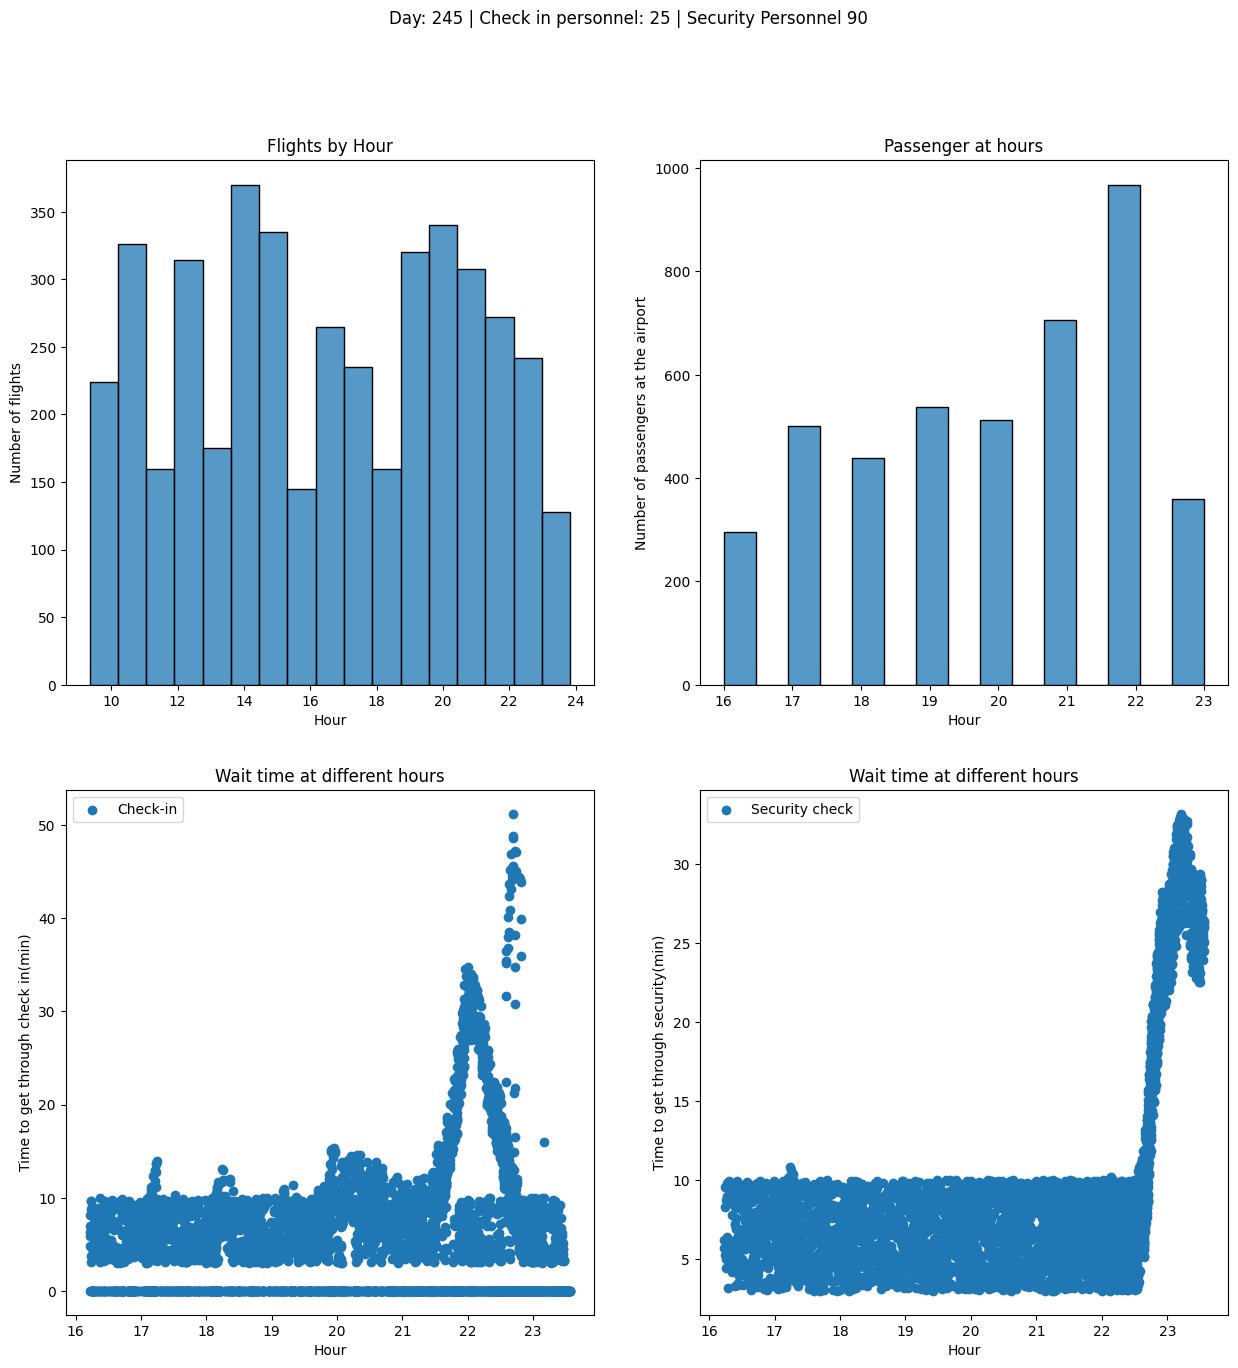

In [80]:
# Process the simulation results and create DataFrames for check-in and security times
checkdf = pd.DataFrame(checkin_times)
checkdf['Hour of arrival'] = ((checkdf[1] - 1440) / 60).astype(int)
checkdf = checkdf.rename(columns={0: 'Airline', 1: 'Arrival', 2: 'Departure', 3:"Total Check in time"})
checkdf['Departure'] = (checkdf['Departure'] - 1440)/60
checkdf['Arrival'] = (checkdf['Arrival'] - 1440)/60

secdf = pd.DataFrame(security_times)
secdf['Hour of arrival'] = ((secdf[1] - 1440) / 60).astype(int)
secdf = secdf.rename(columns={0: 'Start Security Time', 1: 'Arrival', 2: 'Departure', 3:"Total Security Check time"})
secdf['Start Security Time'] = (secdf['Start Security Time'] - 1440)/60

# display(checkdf)

# Create a subplot figure with 3 columns to display histograms and scatter plots
fig, ax = plt.subplots(nrows=1, ncols=3,  figsize=(15,15))
fig.suptitle(f"Day: {testday} | Check in personnel: {check_personnel} | Security Personnel {security_personnel}")

# Plot the histogram of flights by airline
plt.subplot(2, 2, 1)
sns.histplot(data=checkdf, x='Departure')
plt.title(f'Flights by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of flights')

# Plot the histogram of passenger arrivals by hour
plt.subplot(2, 2, 2)
sns.histplot(data=checkdf, x="Hour of arrival")
plt.title('Passenger at hours')
plt.xlabel('Hour')
plt.ylabel('Number of passengers at the airport')

# Plot the scatter plot of wait times at different hours for check-in and security check
plt.subplot(2, 2, 3)
plt.scatter(checkdf['Arrival'].values,checkdf["Total Check in time"].values, label='Check-in')
# plt.scatter(secdf['Start Security Time'].values,secdf["Total Security Check time"].values, label='Security check')
plt.title('Wait time at different hours')
plt.xlabel('Hour')
plt.ylabel('Time to get through check in(min)')
plt.legend()

plt.subplot(2, 2, 4)
# plt.scatter(checkdf['Arrival'].values,checkdf["Total Check in time"].values, label='Check-in')
plt.scatter(secdf['Start Security Time'].values,secdf["Total Security Check time"].values, label='Security check')
plt.title('Wait time at different hours')
plt.xlabel('Hour')
plt.ylabel('Time to get through security(min)')
plt.legend()
plt.show()

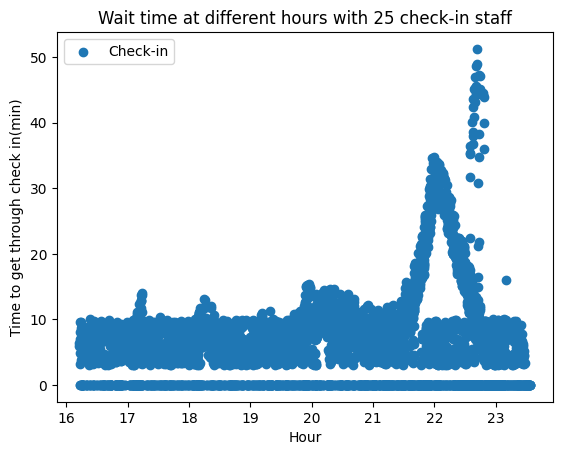

In [81]:
plt.scatter(checkdf['Arrival'].values,checkdf["Total Check in time"].values, label='Check-in')
# plt.scatter(secdf['Start Security Time'].values,secdf["Total Security Check time"].values, label='Security check')
plt.title(f'Wait time at different hours with {check_personnel} check-in staff')
plt.xlabel('Hour')
plt.ylabel('Time to get through check in(min)')
plt.legend()